 #  A Whale off the Port(folio)

 In this assignment, you'll get to use what you've learned this week to evaluate the performance among various algorithmic, hedge, and mutual fund portfolios and compare them against the S&P 500.

In [1]:
import pandas as pd
import numpy as np
import os
import Risk_Kit2 as rk
import datetime as dt
from scipy.optimize import minimize
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
%load_ext autoreload
%autoreload 2
%matplotlib inline

## I used several functions in my analysis: Some of these functions were taken from 2 Coursera courses that I completed: 
## 1. [Introduction to Portfolio Construction and Analysis with Python](https://www.coursera.org/learn/introduction-portfolio-construction-python)
## 2. [Advanced Portfolio Construction and Analysis with Python](https://www.coursera.org/learn/advancedportfolio-construction-python)
## Some of the functions that were taken from these courses were modified to fit the requirements of this assignment. 

# Data Cleaning

In this section, you will need to read the CSV files into DataFrames and perform any necessary data cleaning steps. After cleaning, combine all DataFrames into a single DataFrame.

Files:
1. whale_returns.csv
2. algo_returns.csv
3. sp500_history.csv

## Whale Returns

Read the Whale Portfolio daily returns and clean the data

In [3]:
# Reading whale returns
common_path=Path('Homework_2')
whale_returns_csv=os.path.join(common_path,'whale_returns.csv')
algo_returns_csv=os.path.join(common_path,'algo_returns.csv')
sp500_history_csv=os.path.join(common_path,'sp500_history.csv')

whale_returns=pd.read_csv(whale_returns_csv, index_col='Date', parse_dates=True, infer_datetime_format=True)
whale_returns.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
Date,,,,
2015-03-02,NaN,NaN,NaN,NaN
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569
2015-03-04,0.002230,0.003241,-0.002534,0.004213
2015-03-05,0.004016,0.004076,0.002355,0.006726
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098


In [69]:
# Count nulls
whale_returns.isnull().sum()

SOROS FUND MANAGEMENT LLC      0
PAULSON & CO.INC.              0
TIGER GLOBAL MANAGEMENT LLC    0
BERKSHIRE HATHAWAY INC         0
dtype: int64

In [4]:
# Drop nulls
whale_returns.dropna(inplace=True)
whale_returns.isna().sum()

SOROS FUND MANAGEMENT LLC      0
PAULSON & CO.INC.              0
TIGER GLOBAL MANAGEMENT LLC    0
BERKSHIRE HATHAWAY INC         0
dtype: int64

## Algorithmic Daily Returns

Read the algorithmic daily returns and clean the data

In [5]:
# Reading algorithmic returns
algo_returns=pd.read_csv(algo_returns_csv, index_col='Date', parse_dates=True, infer_datetime_format=True)
algo_returns.head()

,Algo 1,Algo 2
Date,,
2014-05-28,0.001745,NaN
2014-05-29,0.003978,NaN
2014-05-30,0.004464,NaN
2014-06-02,0.005692,NaN
2014-06-03,0.005292,NaN


In [8]:
# Count nulls
algo_returns.isna().sum()

Algo 1    0
Algo 2    6
dtype: int64

In [6]:
# Drop nulls
algo_returns.dropna(inplace=True)
algo_returns.isna().sum()

Algo 1    0
Algo 2    0
dtype: int64

## S&P 500 Returns

Read the S&P500 Historic Closing Prices and create a new daily returns DataFrame from the data. 

In [7]:
# Reading S&P 500 Closing Prices
sp500_returns=pd.read_csv(sp500_history_csv, index_col='Date', parse_dates=True, infer_datetime_format=True)
sp500_returns.sort_index(inplace=True)
sp500_returns.head()

,Close
Date,
2012-10-01,$1444.49
2012-10-02,$1445.75
2012-10-03,$1450.99
2012-10-04,$1461.40
2012-10-05,$1460.93


In [8]:
# Check Data Types
sp500_returns.dtypes

Close    object
dtype: object

In [8]:
# Fix Data Types
sp500_returns['Close']=sp500_returns['Close'].str.replace('$', '')
sp500_returns['Close']=sp500_returns['Close'].astype('float')
sp500_returns.dtypes

Close    float64
dtype: object

In [9]:
# Calculate Daily Returns
sp500_daily_rets=sp500_returns.pct_change()

In [10]:
# Drop nulls
sp500_daily_rets.dropna(inplace=True)
sp500_daily_rets.head()

,Close
Date,
2012-10-02,0.000872
2012-10-03,0.003624
2012-10-04,0.007174
2012-10-05,-0.000322
2012-10-08,-0.003457


In [11]:
# Rename Columns
sp500_daily_rets.columns=(['S&P 500'])

## Combine Whale, Algorithmic, and S&P 500 Returns

In [12]:
# Concatenate all DataFrames into a single DataFrame
combined_df=pd.concat([whale_returns, algo_returns, sp500_daily_rets], axis=1, join='inner')
combined_df.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P 500
Date,,,,,,,
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569,-0.001942,-0.000949,-0.004539
2015-03-04,0.002230,0.003241,-0.002534,0.004213,-0.008589,0.002416,-0.004389
2015-03-05,0.004016,0.004076,0.002355,0.006726,-0.000955,0.004323,0.001196
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098,-0.004957,-0.011460,-0.014174
2015-03-09,0.000582,0.004225,0.005843,-0.001652,-0.005447,0.001303,0.003944


---

# Portfolio Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

## Performance

Calculate and Plot the daily returns and cumulative returns. Does any portfolio outperform the S&P 500? 

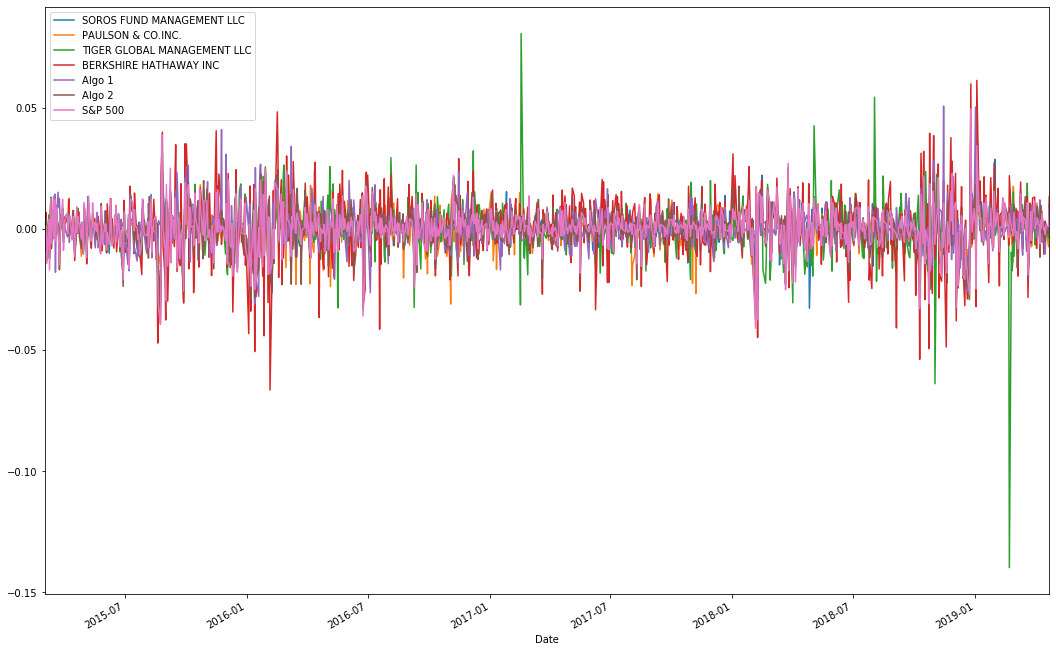

In [13]:
# Plot daily returns
combined_df.plot(figsize=(18,12))

## Algo 1 and Berkshire Hathaway both had better total returns than the S&P 500

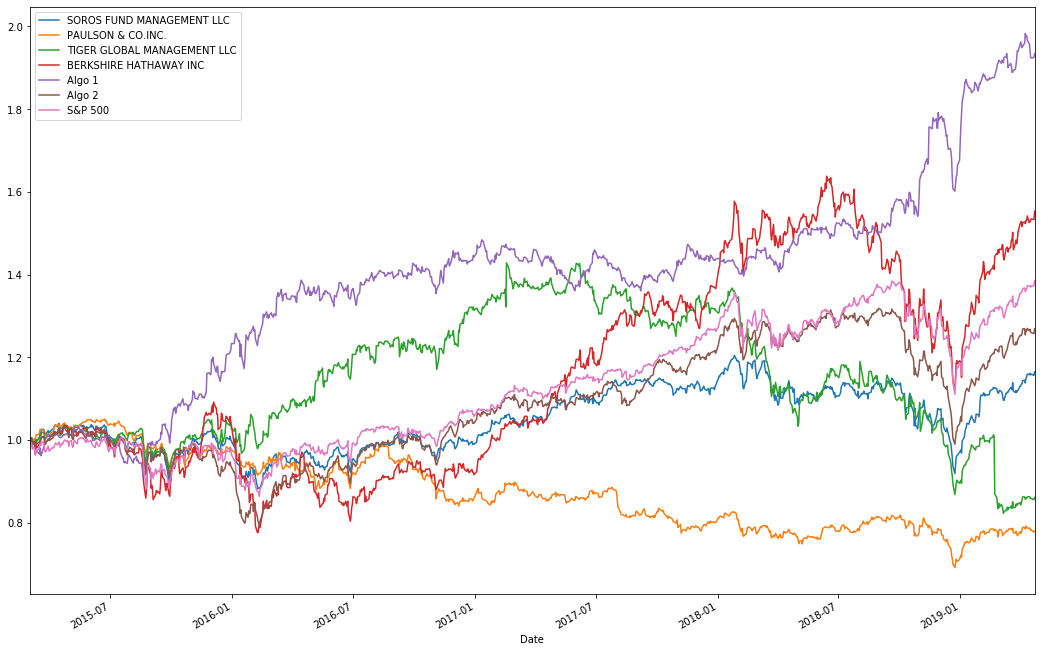

In [14]:
# Plot cumulative returns
(1+combined_df).cumprod().plot(figsize=(18,12))

---

## Risk

Determine the _risk_ of each portfolio:

1. Create a box plot for each portfolio. 
2. Calculate the standard deviation for all portfolios
4. Determine which portfolios are riskier than the S&P 500
5. Calculate the Annualized Standard Deviation

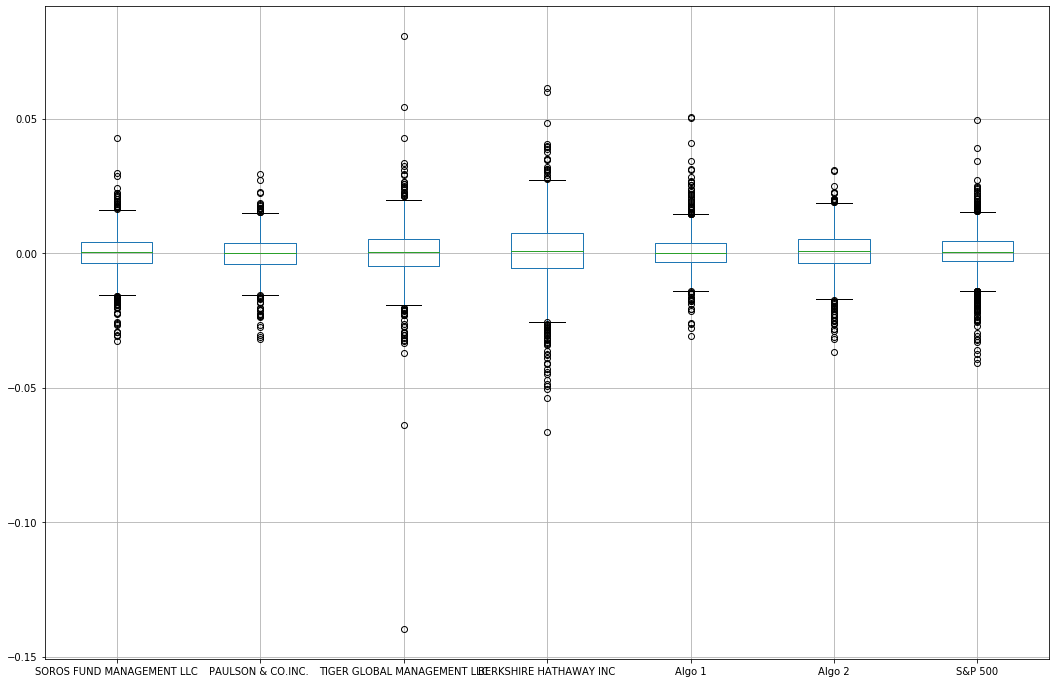

In [15]:
# Box plot to visually show risk
combined_df.boxplot(figsize=(18,12))

In [16]:
# Daily Standard Deviations
# Calculate the standard deviation for each portfolio. 
# Which portfolios are riskier than the S&P 500?
combined_df.std()

SOROS FUND MANAGEMENT LLC      0.007895
PAULSON & CO.INC.              0.007023
TIGER GLOBAL MANAGEMENT LLC    0.010894
BERKSHIRE HATHAWAY INC         0.012919
Algo 1                         0.007620
Algo 2                         0.008342
S&P 500                        0.008554
dtype: float64

### Tiger Global and Berkshire Hathaway both had higher risk than the S&P 500 in terms of volatility

In [17]:
# Determine which portfolios are riskier than the S&P 500
combined_df.std()>combined_df.std()['S&P 500']

SOROS FUND MANAGEMENT LLC      False
PAULSON & CO.INC.              False
TIGER GLOBAL MANAGEMENT LLC     True
BERKSHIRE HATHAWAY INC          True
Algo 1                         False
Algo 2                         False
S&P 500                        False
dtype: bool

### Annualized Standard Deviation

In [18]:
combined_df.std()*np.sqrt(252)

SOROS FUND MANAGEMENT LLC      0.125335
PAULSON & CO.INC.              0.111488
TIGER GLOBAL MANAGEMENT LLC    0.172936
BERKSHIRE HATHAWAY INC         0.205077
Algo 1                         0.120967
Algo 2                         0.132430
S&P 500                        0.135786
dtype: float64

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Plot the rolling standard deviation of the various portfolios along with the rolling standard deviation of the S&P 500 (consider a 21 day window). Does the risk increase for each of the portfolios at the same time risk increases in the S&P?
2. Construct a correlation table for the algorithmic, whale, and S&P 500 returns. Which returns most closely mimic the S&P?
2. Choose one portfolio and plot a rolling beta between that portfolio's returns and S&P 500 returns. Does the portfolio seem sensitive to movements in the S&P 500?

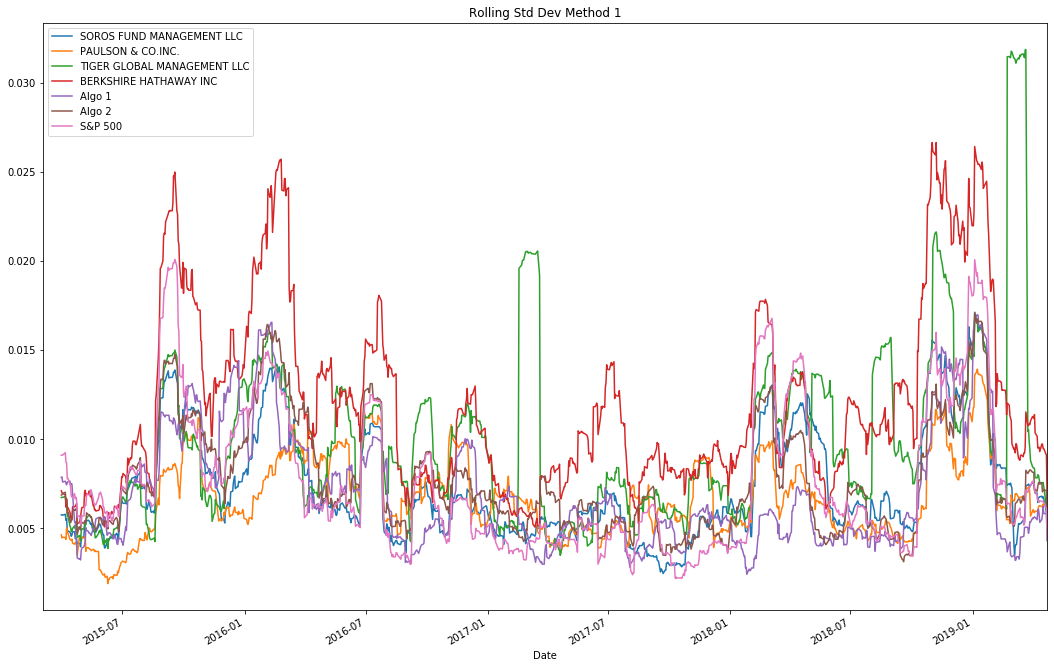

In [20]:
# Calculate and plot the rolling standard deviation for
# the S&P 500 and whale portfolios using a 21 trading day window
combined_df.rolling(21).std().plot(figsize=(18,12), title='Rolling Std Dev Method 1')

### It looks like volatility for most of the portfolios rises as the volatility of the S&P 500 rises, however, Tiger Global's volatility seems to spike upwards at random times. It has risen both when the S&P's volatility is rising but also when the S&P's volatility is falling

---

### Method 2: Here I construct my own rolling windows of size 21. I then return a list of the returns from the for each window.
* ## I used the following function

In [21]:
def get_rolled_returns(rets, window_length):
    n_periods=rets.shape[0]
    start=n_periods-window_length
    windows=[(x, x+window_length) for x in range(start)]
    rolled_returns=[rets.iloc[win[0]:win[1]] for win in windows]
    return rolled_returns

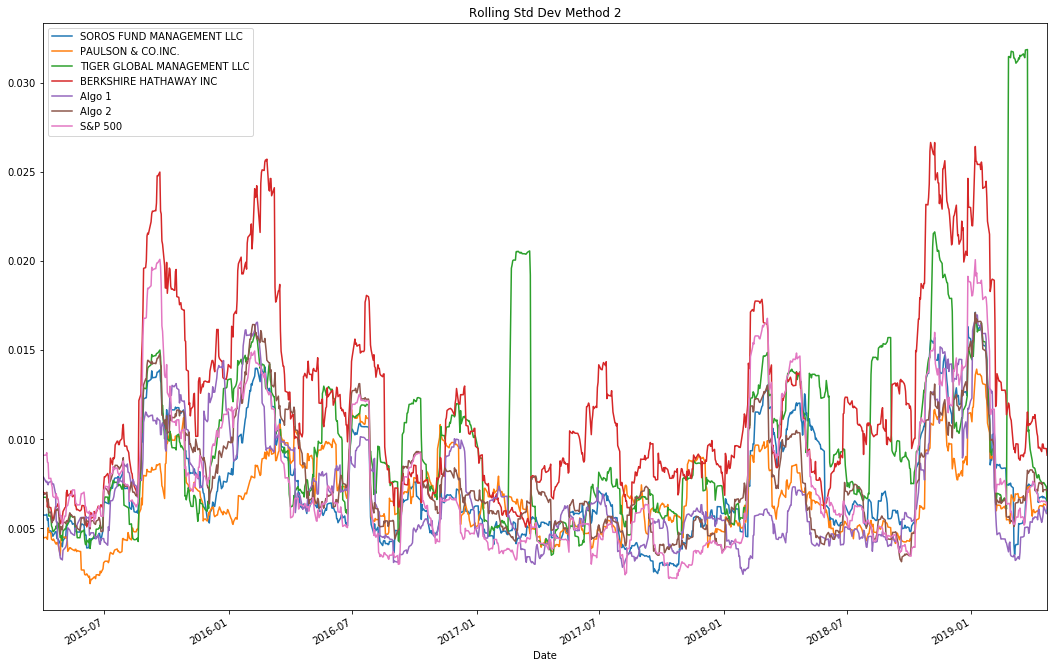

In [22]:
rolled_rets=get_rolled_returns(combined_df, 21)
rolled_std=pd.DataFrame(data=[r.std() for r in rolled_rets], index=combined_df.index[21:], columns=combined_df.columns)
rolled_std.plot(figsize=(18,12), title='Rolling Std Dev Method 2')

In [23]:
# Construct a correlation table
combined_df.corr()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P 500
SOROS FUND MANAGEMENT LLC,1.000000,0.699914,0.561243,0.754360,0.321211,0.826873,0.837864
PAULSON & CO.INC.,0.699914,1.000000,0.434479,0.545623,0.268840,0.678152,0.669732
TIGER GLOBAL MANAGEMENT LLC,0.561243,0.434479,1.000000,0.424423,0.164387,0.507414,0.623946
BERKSHIRE HATHAWAY INC,0.754360,0.545623,0.424423,1.000000,0.292033,0.688082,0.751371
Algo 1,0.321211,0.268840,0.164387,0.292033,1.000000,0.288243,0.279494
Algo 2,0.826873,0.678152,0.507414,0.688082,0.288243,1.000000,0.858764
S&P 500,0.837864,0.669732,0.623946,0.751371,0.279494,0.858764,1.000000


In [24]:
combined_df.corr()[combined_df.corr().iloc[:,-1]<1].idxmax()

SOROS FUND MANAGEMENT LLC        SOROS FUND MANAGEMENT LLC
PAULSON & CO.INC.                       PAULSON & CO.INC. 
TIGER GLOBAL MANAGEMENT LLC    TIGER GLOBAL MANAGEMENT LLC
BERKSHIRE HATHAWAY INC              BERKSHIRE HATHAWAY INC
Algo 1                                              Algo 1
Algo 2                                              Algo 2
S&P 500                                             Algo 2
dtype: object

### We can see that Algo 2 is the most highly correlated with the S&P 500

### Rolling Beta for Tiger Global

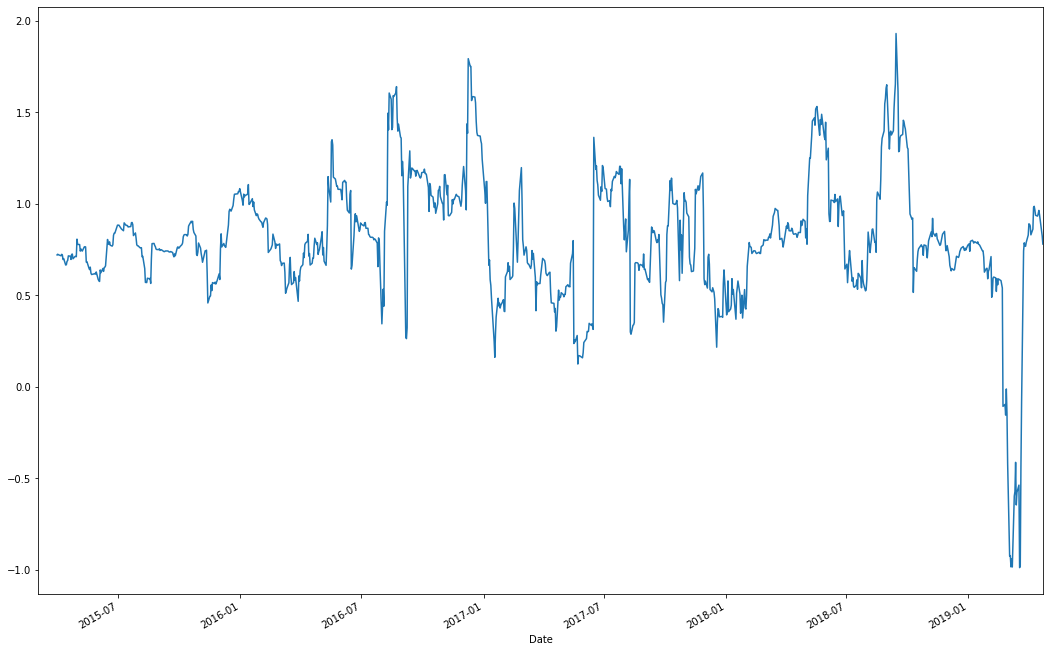

In [25]:
# Calculate Beta for a single portfolio compared to the total market (S&P 500)
# (Your graph may differ, dependent upon which portfolio you are comparing)
rolling_cov=combined_df['TIGER GLOBAL MANAGEMENT LLC'].rolling(21).cov(combined_df['S&P 500'])
rolling_market_var=combined_df['S&P 500'].rolling(21).var()
rolling_beta=rolling_cov/rolling_market_var
rolling_beta.plot(figsize=(18,12))

### Rolling Beta of Tiger Global found by constructing windows for each 21 day return period. Results look pretty close to Method 1.
* ### I used the following function

In [26]:
def get_beta_from_windows(all_rets, rets, window_length): 
    rolling_betas=[find_Beta(r) for r in rets]
    return pd.DataFrame(data=rolling_betas, index=all_rets.index[window_length:], columns=all_rets.columns)

def find_Beta(rets):
    corr_mat=rets.corr()
    location=rets.columns.get_loc('S&P 500')
    vols=rets.std()
    covmat=(corr_mat.mul(vols, axis=0)).mul(vols.T, axis=1)
    cov_market=pd.DataFrame(covmat.iloc[location,:])
    market_var=cov_market.iloc[location]
    beta_mat=cov_market/market_var[0]
    return beta_mat['S&P 500']

### Tiger Global looks to be extremely sensitive to market movements. It's beta gets near 2 which I think is very high as it means that TIGER can move twice as much as the market at times. It seems to range between 2 and around .2-.3, but during a period in 2019 the beta dropped to -1 all of a sudden. Maybe the manager suddenly switched to negatively correlated assets as a defensive move? 

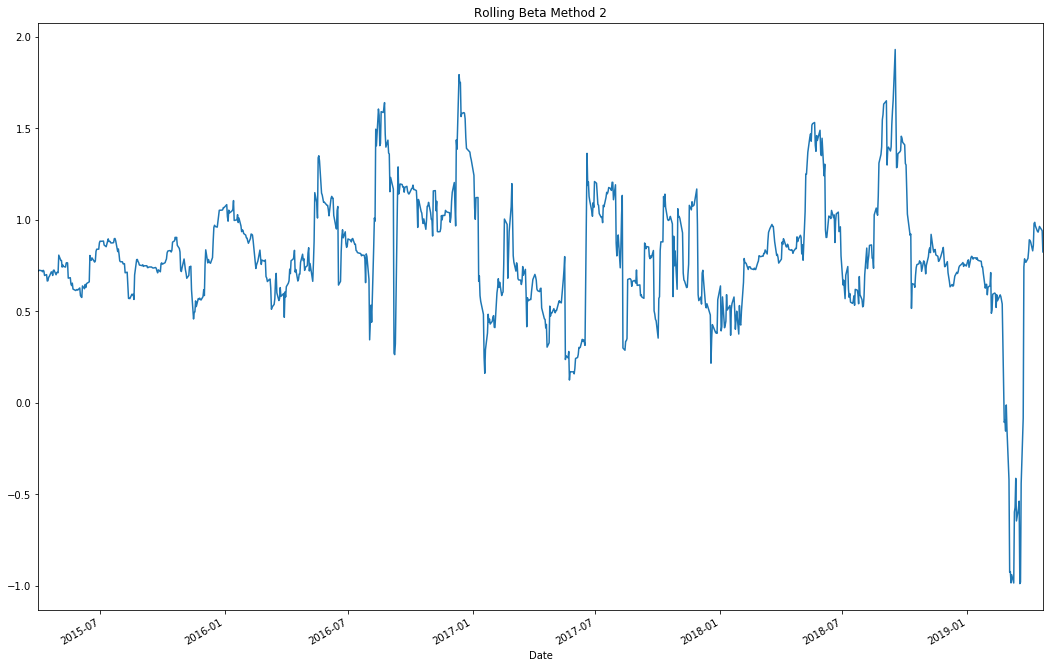

In [28]:
rolled_betas=get_beta_from_windows(combined_df, rolled_rets, 21)
rolled_betas['TIGER GLOBAL MANAGEMENT LLC'].plot(figsize=(18,12), title='Rolling Beta Method 2')

### Exponentially Weighted Average using the built-in 'ewm' function, using 21 as the halflife parameter. I also used the following formula to calculate alpha based on a halflife of 21 periods and graphed the result. THe result was similar. This formula for alpha was found in the documentation of the ewm method

## $\alpha$ = 1 - $e^{ln(0.5) / halflife}$

### Challenge: Exponentially Weighted Average 

An alternative way to calculate a rollwing window is to take the exponentially weighted moving average. This is like a moving window average, but it assigns greater importance to more recent observations. Try calculating the `ewm` with a 21 day half-life.

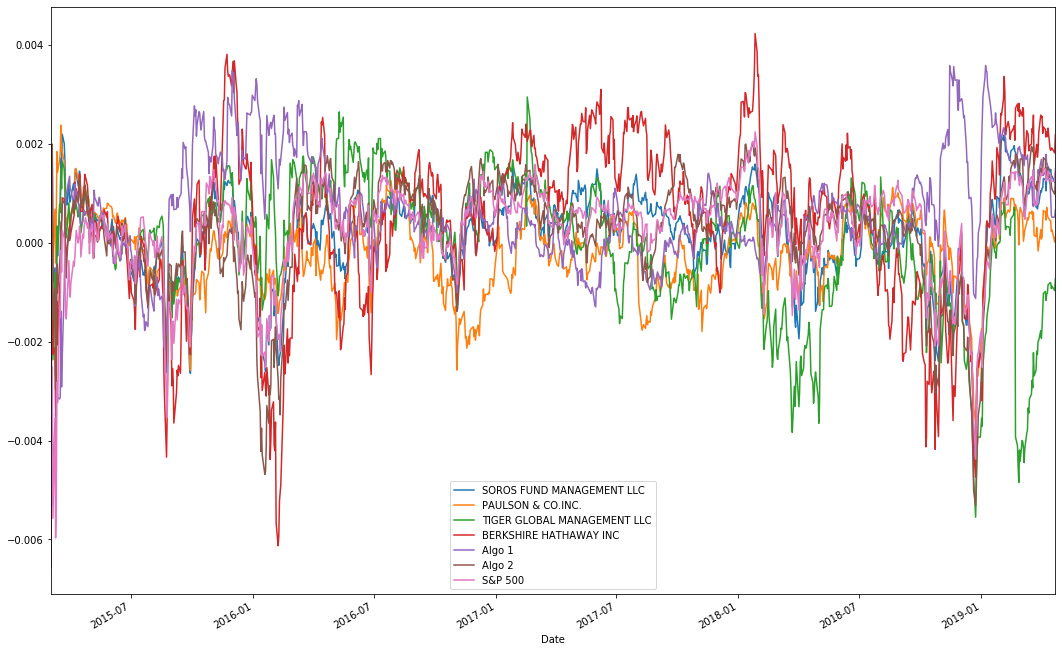

In [29]:
# (OPTIONAL) YOUR CODE HERE
combined_df_ewm=combined_df.ewm(halflife=21).mean()
combined_df_ewm.plot(figsize=(18,12))

### Method 2: Here I use the returns on the 20th trading day as my initial EMA (Exponentially Weighted Average). Then I use the following formula to calculate the next period's EMA: I use N=21
## $EMA_{t}$ =($Returns_t$ - $EMA_{t-1}$)*$\frac{2}{N+1}$+$EMA_{t-1}$
* ### I used the following function

In [30]:
def get_my_ema(rets, window_length):
    n_times=rets.shape[0]-window_length
    ema_list=[]
    ema_list.append(rets.iloc[window_length-1])
    k=2/(window_length+1)
    x=1
    for x in range(1,n_times):
        ema_list.append((rets.iloc[window_length-1+x]-ema_list[x-1])*k+ema_list[x-1])
    return pd.DataFrame(data=ema_list, index=rets.index[window_length:], columns=rets.columns)

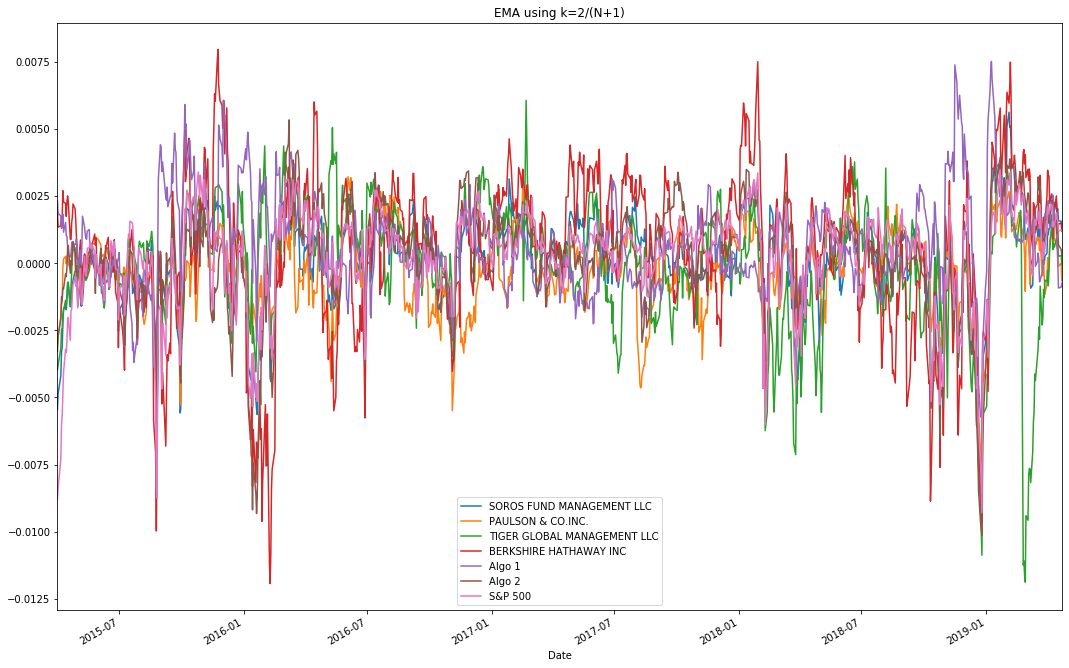

In [31]:
## Method 2
combined_df_ema=get_my_ema(combined_df, 21)
combined_df_ema.plot(figsize=(18,12), title='EMA using k=2/(N+1)')

## Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. (After all, if you could invest in one of two portfolios, each offered the same 10% return, yet one offered lower risk, you'd take that one, right?)

Calculate and plot the annualized Sharpe ratios for all portfolios to determine which portfolio has the best performance

In [32]:
# Annualized Sharpe Ratios
sharpes=(combined_df.mean()*252)/(combined_df.std()*np.sqrt(252))
sharpes

SOROS FUND MANAGEMENT LLC      0.356417
PAULSON & CO.INC.             -0.483570
TIGER GLOBAL MANAGEMENT LLC   -0.121060
BERKSHIRE HATHAWAY INC         0.621810
Algo 1                         1.378648
Algo 2                         0.501364
S&P 500                        0.648267
dtype: float64

### Sharpe Ratios show that Algo 1 outperforms every other portfolio. Algo 2 outperforms 3 managers, but has a lower Sharpe than Berkshire Hathaway and the S&P 500

### Sortino Ratios
* ### I used the following functions

In [33]:
def sortino_ratio(r, riskfree_rate, periods_per_year):
    rf_per_period=(1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret=r-rf_per_period
    ann_ex_ret=annualize_rets(excess_ret, periods_per_year)
    ann_neg_vol=annualize_vol(r[r<0], periods_per_year)
    return ann_ex_ret/ann_neg_vol

def annualize_vol(r, periods_per_year):
    return r.std()*(periods_per_year**.5)

def annualize_rets(r, periods_per_year):
    compounded_growth=(1+r).prod()
    n_periods=r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [34]:
sortino_ratio(combined_df, 0, 252)

SOROS FUND MANAGEMENT LLC      0.390080
PAULSON & CO.INC.             -0.708171
TIGER GLOBAL MANAGEMENT LLC   -0.237255
BERKSHIRE HATHAWAY INC         0.699785
Algo 1                         2.427960
Algo 2                         0.593063
S&P 500                        0.746851
dtype: float64

 ### plot() these sharpe ratios using a barplot. On the basis of this performance metric, do our algo strategies outperform both 'the market' and the whales?
 * ### Algo 1 outperforms everything else by far. Algo 2 is in the middle of the pack. Interestingly, Algo 1's lead over the other portfolios increases when we use the Sortino ratio and only consider the downside volatility. 

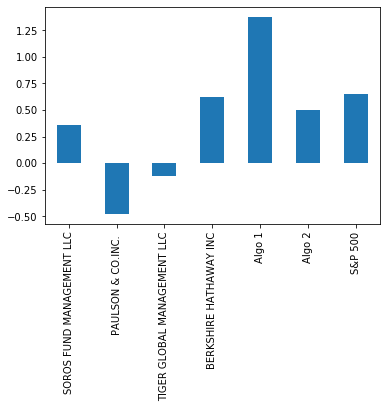

In [35]:
# Visualize the sharpe ratios as a bar plot
sharpes.plot.bar()

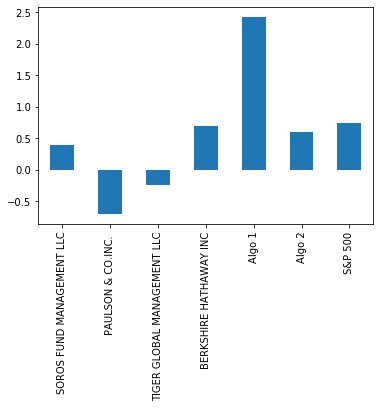

In [36]:
# Sortino Ratios
sortino_ratio(combined_df, 0, 252).plot.bar()

---

# Portfolio Returns

In this section, you will build your own portfolio of stocks, calculate the returns, and compare the results to the Whale Portfolios and the S&P 500. 

1. Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.
2. Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock
3. Join your portfolio returns to the DataFrame that contains all of the portfolio returns
4. Re-run the performance and risk analysis with your portfolio to see how it compares to the others
5. Include correlation analysis to determine which stocks (if any) are correlated

## Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.

In [37]:
my_stocks=pd.read_csv('3_5_stocks.csv')
my_stocks

,Date,Close,Date.1,Close.1,Date.2,Close.2,Date.3,Close.3,Date.4,Close.4
0,3/3/2015 16:00:00,102.34,3/3/2015 16:00:00,56.46,3/3/2015 16:00:00,87.62,3/3/2015 16:00:00,7.13,3/3/2015 16:00:00,81.58
1,3/4/2015 16:00:00,101.65,3/4/2015 16:00:00,55.79,3/4/2015 16:00:00,87.18,3/4/2015 16:00:00,6.88,3/4/2015 16:00:00,85.49
2,3/5/2015 16:00:00,102.52,3/5/2015 16:00:00,55.50,3/5/2015 16:00:00,86.74,3/5/2015 16:00:00,6.53,3/5/2015 16:00:00,86.10
3,3/6/2015 16:00:00,100.11,3/6/2015 16:00:00,53.37,3/6/2015 16:00:00,85.63,3/6/2015 16:00:00,6.42,3/6/2015 16:00:00,84.40
4,3/9/2015 16:00:00,100.66,3/9/2015 16:00:00,53.83,3/9/2015 16:00:00,85.16,3/9/2015 16:00:00,6.23,3/9/2015 16:00:00,82.53
...,...,...,...,...,...,...,...,...,...,...
1038,4/16/2019 16:00:00,138.02,4/16/2019 16:00:00,56.39,4/16/2019 16:00:00,81.20,4/16/2019 16:00:00,13.57,4/16/2019 16:00:00,185.78
1039,4/17/2019 16:00:00,138.52,4/17/2019 16:00:00,56.18,4/17/2019 16:00:00,81.43,4/17/2019 16:00:00,13.27,4/17/2019 16:00:00,187.55
1040,4/18/2019 16:00:00,137.52,4/18/2019 16:00:00,54.37,4/18/2019 16:00:00,81.13,4/18/2019 16:00:00,13.32,4/18/2019 16:00:00,186.94
1041,4/22/2019 16:00:00,137.83,4/22/2019 16:00:00,54.61,4/22/2019 16:00:00,82.90,4/22/2019 16:00:00,13.06,4/22/2019 16:00:00,185.38


* # JNJ

In [38]:
# Read the first stock
jnj=my_stocks.iloc[:,[0,1]]
jnj.set_index(['Date'], inplace=True)
jnj.index=pd.to_datetime(jnj.index)
jnj.insert(0, column='Symbol', value='JNJ')
jnj.index=jnj.index.normalize()
jnj.head()

,Symbol,Close
Date,,
2015-03-03,JNJ,102.34
2015-03-04,JNJ,101.65
2015-03-05,JNJ,102.52
2015-03-06,JNJ,100.11
2015-03-09,JNJ,100.66


* # MO

In [39]:
# Read the second stock
mo=my_stocks.iloc[:,2:4]
mo.set_index(['Date.1'], inplace=True)
mo.index=pd.to_datetime(mo.index)
mo.insert(0, column='Symbol', value='MO')
mo.index=mo.index.normalize()
mo.rename(columns={'Close.1': 'Close'}, inplace=True)
mo.index.name='Date'
mo.head()

,Symbol,Close
Date,,
2015-03-03,MO,56.46
2015-03-04,MO,55.79
2015-03-05,MO,55.50
2015-03-06,MO,53.37
2015-03-09,MO,53.83


* # XOM

In [40]:
# Read the third stock
xom=my_stocks.iloc[:,4:6]
xom.set_index(['Date.2'], inplace=True)
xom.index=pd.to_datetime(xom.index)
xom.insert(0, column='Symbol', value='XOM')
xom.index=xom.index.normalize()
xom.rename(columns={'Close.2': 'Close'}, inplace=True)
xom.index.name='Date'
xom.head()

,Symbol,Close
Date,,
2015-03-03,XOM,87.62
2015-03-04,XOM,87.18
2015-03-05,XOM,86.74
2015-03-06,XOM,85.63
2015-03-09,XOM,85.16


* # VALE

In [41]:
vale=my_stocks.iloc[:,6:8]
vale.set_index(['Date.3'], inplace=True)
vale.index=pd.to_datetime(vale.index)
vale.insert(0, column='Symbol', value='VALE')
vale.index=vale.index.normalize()
vale.rename(columns={'Close.3': 'Close'}, inplace=True)
vale.index.name='Date'
vale.head()

,Symbol,Close
Date,,
2015-03-03,VALE,7.13
2015-03-04,VALE,6.88
2015-03-05,VALE,6.53
2015-03-06,VALE,6.42
2015-03-09,VALE,6.23


* # BABA

In [42]:
baba=my_stocks.iloc[:,8:10]
baba.set_index(['Date.4'], inplace=True)
baba.index=pd.to_datetime(baba.index)
baba.insert(0, column='Symbol', value='BABA')
baba.index=baba.index.normalize()
baba.rename(columns={'Close.4': 'Close'}, inplace=True)
baba.index.name='Date'
baba.head()

,Symbol,Close
Date,,
2015-03-03,BABA,81.58
2015-03-04,BABA,85.49
2015-03-05,BABA,86.10
2015-03-06,BABA,84.40
2015-03-09,BABA,82.53


# Concatenate all stocks into a single DataFrame

In [43]:
my_stocks=pd.concat([jnj,mo,xom,vale,baba], axis=1, join='inner')
my_stocks=my_stocks.drop(columns=my_stocks.columns[::2])
my_stocks.columns=(['JNJ', 'MO', 'XOM', 'VALE', 'BABA'])
my_stocks.head()

,JNJ,MO,XOM,VALE,BABA
Date,,,,,
2015-03-03,102.34,56.46,87.62,7.13,81.58
2015-03-04,101.65,55.79,87.18,6.88,85.49
2015-03-05,102.52,55.50,86.74,6.53,86.10
2015-03-06,100.11,53.37,85.63,6.42,84.40
2015-03-09,100.66,53.83,85.16,6.23,82.53


In [44]:
# Pivot so that each column of prices represents a unique symbol
my_stocks=my_stocks.rename_axis('Symbol', axis=1)
my_stocks.head()

Symbol,JNJ,MO,XOM,VALE,BABA
Date,,,,,
2015-03-03,102.34,56.46,87.62,7.13,81.58
2015-03-04,101.65,55.79,87.18,6.88,85.49
2015-03-05,102.52,55.50,86.74,6.53,86.10
2015-03-06,100.11,53.37,85.63,6.42,84.40
2015-03-09,100.66,53.83,85.16,6.23,82.53


In [45]:
# Drop Nulls
my_stocks.dropna(inplace=True)
my_stocks.head()

Symbol,JNJ,MO,XOM,VALE,BABA
Date,,,,,
2015-03-03,102.34,56.46,87.62,7.13,81.58
2015-03-04,101.65,55.79,87.18,6.88,85.49
2015-03-05,102.52,55.50,86.74,6.53,86.10
2015-03-06,100.11,53.37,85.63,6.42,84.40
2015-03-09,100.66,53.83,85.16,6.23,82.53


## Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock

### I construct 5 differently weighted portfolios: 
* ## 1: Equally weighted

In [46]:
# Calculate weighted portfolio returns
equal_weights = pd.Series(1/5, index=my_stocks.columns)
my_stock_returns=my_stocks.pct_change()
my_EW_rets=(equal_weights*my_stock_returns).sum(axis=1)
my_EW_rets

Date
2015-03-03    0.000000
2015-03-04   -0.002153
2015-03-05   -0.009085
2015-03-06   -0.022255
2015-03-09   -0.008625
                ...   
2019-04-16    0.008958
2019-04-17   -0.001970
2019-04-18   -0.008521
2019-04-22    0.000124
2019-04-23    0.008676
Length: 1043, dtype: float64

* ## 2: Global Minimum Variance Portfolio. Found by assuming that expected returns of each portfolio are equal to 1, and then using the 'minimize' function to find the minimum 'Negative Sharpe Ratio'. This will be the portfolio with the highest normal Sharpe ratio, and therefore the portfolio with the lowest variance

In [47]:
# Construct GMV Portfolio
my_gmv_portfolio_weights=rk.gmv(my_stock_returns.cov())
my_gmv_portfolio=my_stock_returns@my_gmv_portfolio_weights
my_gmv_portfolio

Date
2015-03-03         NaN
2015-03-04   -0.003410
2015-03-05    0.001780
2015-03-06   -0.024417
2015-03-09    0.001551
                ...   
2019-04-16    0.005115
2019-04-17    0.002047
2019-04-18   -0.012351
2019-04-22    0.006605
2019-04-23    0.009669
Length: 1043, dtype: float64

* ## 3: Max Sharpe Ratio portfolio: I find Expected Returns using the 'predict' method of the LinearRegression class

### I use return premiums for the Fama-French factors as my explanatory variables: exp_var. This is monthly data, so I need  to convert my daily stock return data to monthly using the resample function with parameter '1M'. I confirm that this procedure is giving me correct total monthly returns by grouping the stock returns by year and month and then summing them. Then I make the monthly stock return index compatible by dropping the 'day' portion, so that it matches the Fama-French index. Then I proceed with the regression, using 50% of the data as a training set, and the remainder as an out of sample testing set

In [49]:
fama_french=rk.get_fff_m_returns()
mkt_excess=fama_french[['Mkt-RF']]           
exp_var=mkt_excess.copy()
exp_var['Constant']=1
exp_var['SMB']=fama_french['SMB']
exp_var['HML']=fama_french['HML']
exp_var['RF']=fama_french['RF']

In [50]:
exp_var=exp_var.loc['2015-03':]
exp_var.drop(columns=['Constant', 'RF'], inplace=True)

my_stock_returns_monthly=my_stock_returns.copy()
my_stock_returns_monthly=my_stock_returns_monthly.resample('1M').sum()
my_stock_returns_monthly.index=my_stock_returns_monthly.index.strftime('%Y-%m')
my_stock_returns_monthly=my_stock_returns_monthly.loc[:'2018-12']

X=exp_var.values
Y=my_stock_returns_monthly.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
my_regressor=LinearRegression()
my_regressor.fit(X_train, Y_train)
df_regression=pd.DataFrame(my_regressor.coef_, index=my_stock_returns_monthly.columns, columns=exp_var.columns)

In [62]:
grouped_rets=my_stock_returns.groupby([my_stock_returns.index.year, my_stock_returns.index.month]).sum()
grouped_rets.head()

Symbol          JNJ        MO       XOM      VALE      BABA
Date Date                                                  
2015 3    -0.015818 -0.119438 -0.029107 -0.220872  0.022459
     4    -0.013471  0.001868  0.028297  0.330905 -0.021273
     5     0.010078  0.023965 -0.024330 -0.184355  0.098747
     6    -0.026509 -0.044105 -0.023323 -0.057219 -0.080481
     7     0.028360  0.107980 -0.046711 -0.097018 -0.046912

In [61]:
my_stock_returns_monthly.head()

Symbol,JNJ,MO,XOM,VALE,BABA
2015-03,-0.015818,-0.119438,-0.029107,-0.220872,0.022459
2015-04,-0.013471,0.001868,0.028297,0.330905,-0.021273
2015-05,0.010078,0.023965,-0.024330,-0.184355,0.098747
2015-06,-0.026509,-0.044105,-0.023323,-0.057219,-0.080481
2015-07,0.028360,0.107980,-0.046711,-0.097018,-0.046912


In [51]:
df_regression

,Mkt-RF,SMB,HML
Symbol,,,
JNJ,0.539400,-0.518792,-0.348539
MO,0.369444,-1.395942,0.361920
XOM,1.048292,0.088621,0.383012
VALE,1.518237,-2.033449,2.412702
BABA,2.670996,-0.093738,0.104801


In [52]:
Y_predictions=my_regressor.predict(X_test)

## Because my 'test-size' parameter was 0.5, 'Y_predictions' has only half of the rows of the original monthly stock returns. This is why I use '[-23]' for the index parameter.

In [53]:
df_predict=pd.DataFrame(data=Y_predictions, index=exp_var.index[-23:], columns=my_stock_returns_monthly.columns)
df_predict
my_expected_returns_monthly=df_predict.mean(axis=0)
my_expected_covariance=df_predict.cov()
my_expected_returns_monthly

Symbol
JNJ     0.005276
MO     -0.017801
XOM     0.001030
VALE   -0.014211
BABA    0.034176
dtype: float64

In [63]:
df_predict.head()

Symbol,JNJ,MO,XOM,VALE,BABA
2017-02,0.009694,-0.027035,-0.002524,-0.053858,0.036978
2017-03,0.026425,-0.002650,0.001465,-0.026600,0.060400
2017-04,0.019306,0.011444,0.009970,0.040382,0.061506
2017-05,0.045124,0.034576,-0.010626,-0.001559,0.051236
2017-06,-0.020031,0.019192,-0.062741,0.021667,-0.138226


### The predicted average returns for MO and VALE are negative. I don't think these are reliable values, since no stock would have negative expected returns. It's probably due to the small number of observations.

## I use the following functions to find weights that will maximize the Sharpe Ratio given the the expected monthly returns and their covariance

In [64]:
def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**.5


def msr(riskfree_rate, er, cov):
    """
    Risk Free Rate + ER + Cov -----> Weight array
    """
    n=er.shape[0]
    initial_guess=np.repeat(1/n, n)
    #constraints
    bounds=((0,1), )*n
 
    weights_sum_to_1={
        'type': 'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio, given weights
        """
        rets=portfolio_return(weights, er)
        vol=portfolio_vol(weights, cov)
        return -(rets-riskfree_rate)/vol

    results=minimize(neg_sharpe_ratio, initial_guess,
                                   args=(riskfree_rate, er, cov,), method="SLSQP",
                                   options={'disp': False},
                                   constraints=(weights_sum_to_1),
                                   bounds=bounds
                                  )
    return results.x

def gmv(cov):
    """
    Returns the weight array of the Global Minimum Variance portfolio
    """
    n=cov.shape[0]
    return msr(0, np.repeat(1,n), cov)


## I need to convert my predicted returns into daily returns if I want to be able to concatenate this portfolio to the others. So I take my predicted monthly returns and divide them by 21. Then I 'resize' the dataframe so that it contains 1043 rows
## To do this, I simply repeat the same sequence of returns 45 times (45*23=1035) and then I just add the first 8 rows to the end so that my total rows are 1043 which matches my daily stock data. I also change the datetimeIndex format to include days so that it will be compatible with the other portfolios

In [65]:
my_predicted_max_sharpe_weights=msr(0, my_expected_returns_monthly, df_predict.cov())
my_predicted_max_sharpe=((df_predict/21)@my_predicted_max_sharpe_weights)
my_predicted_max_sharpe
my_predicted_max_sharpe.index=my_predicted_max_sharpe.index.strftime('%Y-%m-%d')

In [66]:
my_predicted_max_sharpe=pd.concat([my_predicted_max_sharpe]*45)
my_predicted_max_sharpe=pd.concat([my_predicted_max_sharpe, my_predicted_max_sharpe.iloc[0:8]])
my_predicted_max_sharpe_weights

array([4.86952244e-01, 0.00000000e+00, 0.00000000e+00, 2.02745806e-16,
       5.13047756e-01])

In [67]:
my_predicted_max_sharpe.index=my_EW_rets.index

* ## 4: Next is an equal risk contribution portfolio. The stocks are weighted so that each stock contributes equally to the volatility of the portfolio. Again I use optimization: I minimize the mean-squared difference between calculated risk contribution and target (equal) risk contribution.
* ### I used the following functions

In [68]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, 
    given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib



def target_risk_contributions(target_risk, cov):
    """
    Minimizes squared difference from target risk
    
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Calls target_risk_contributions with an equally weighted Series
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

In [69]:
# Contruct portfolio where each stock contributes equally to risk. Equally weighted risk portfolio
eq_risk_cont_weights=equal_risk_contributions(my_stock_returns.cov())
eq_risk_returns=my_stock_returns@eq_risk_cont_weights
eq_risk_returns

Date
2015-03-03         NaN
2015-03-04   -0.001520
2015-03-05   -0.003407
2015-03-06   -0.023728
2015-03-09   -0.003596
                ...   
2019-04-16    0.006359
2019-04-17    0.000253
2019-04-18   -0.011204
2019-04-22    0.003579
2019-04-23    0.008798
Length: 1043, dtype: float64

* ## 5: Finally, I construct a momentum based portfolio. The following function finds the best performer for a given day. The best performer is then overweighted the following day. So this is a trailing 24 hour momentum strategy. Weights can be customized: the 2nd parameter will be the weight on the following day for the top performing stock. The other four stocks are equally weighted, and their sum totals whatever is left after subtracting the top performer's weight from 1.0.
* ### I used the following function

In [70]:
def ride_winner(df, weight_for_winner):
    symbol=''
    val=0
    location=-1
    n=len(df.columns)
    rows=df.shape[0]
    rest=1-weight_for_winner
    weight_list=None
    weighted_rets=pd.DataFrame().reindex_like(df)
    weighted_rets=df.copy()
    for x in range(1, rows-1):
        val=(df.iloc[x]).max()
        symbol=(df.iloc[x]).idxmax()
        location=df.columns.get_loc(symbol)
        weight_list=pd.Series(rest/(n-1), range(0,n))
        weight_list.at[location]=weight_for_winner
        
        weighted_rets.iloc[x+1]=df.iloc[x+1]*weight_list.values
    return weighted_rets.sum(axis=1)

### Then I define 2 different momentum portfolios. One assigns a weight of 50% to the previous day's top performer, and the other goes all-in by weighting the previous day's top performer by 100%

In [71]:
momentum_weighted_rets=ride_winner(my_stock_returns, .5)
momentum_weighted_rets_100=ride_winner(my_stock_returns, 1)

## Join your custom portfolio returns to the DataFrame that contains all of the portfolio returns

In [72]:
# Add your "Custom" portfolio to the larger dataframe of fund returns
all_returns=pd.concat([combined_df, my_EW_rets], axis=1, join='inner')
all_returns.rename(columns={0:'Equal Dollar Returns'}, inplace=True)
all_returns=pd.concat([all_returns,my_gmv_portfolio], axis=1, join='inner')
all_returns.rename(columns={0: 'GMV Portfolio'}, inplace=True)
all_returns.dropna(inplace=True)
all_returns=pd.concat([all_returns, my_predicted_max_sharpe], axis=1, join='inner')
all_returns.rename(columns={0:'Max Sharpe Portfolio'}, inplace=True)
all_returns=pd.concat([all_returns, eq_risk_returns], axis=1, join='inner')
all_returns.rename(columns={0:'Equal Risk Contribution'}, inplace=True)
all_returns=pd.concat([all_returns, momentum_weighted_rets], axis=1, join='inner')
all_returns.rename(columns={0:'Momentum'}, inplace=True)
all_returns=pd.concat([all_returns, momentum_weighted_rets_100], axis=1, join='inner')
all_returns.rename(columns={0:'Momentum 100%'}, inplace=True)

In [73]:
# Only compare dates where return data exists for all the stocks (drop NaNs)
all_returns.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P 500,Equal Dollar Returns,GMV Portfolio,Max Sharpe Portfolio,Equal Risk Contribution,Momentum,Momentum 100%
Date,,,,,,,,,,,,,
2015-03-04,0.002230,0.003241,-0.002534,0.004213,-0.008589,0.002416,-0.004389,-0.002153,-0.003410,0.002088,-0.001520,-0.010765,-0.010765
2015-03-05,0.004016,0.004076,0.002355,0.006726,-0.000955,0.004323,0.001196,-0.009085,0.001780,0.001950,-0.003407,-0.003002,0.007135
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098,-0.004957,-0.011460,-0.014174,-0.022255,-0.024417,0.002298,-0.023728,-0.022724,-0.023508
2015-03-09,0.000582,0.004225,0.005843,-0.001652,-0.005447,0.001303,0.003944,-0.008625,0.001551,-0.003841,-0.003596,-0.007449,-0.005489
2015-03-10,-0.010263,-0.005341,-0.012079,-0.009739,-0.001392,-0.012155,-0.016961,-0.008523,-0.009915,0.002311,-0.008871,-0.009715,-0.011704


## Re-run the performance and risk analysis with your portfolio to see how it compares to the others

### Annualized Standard Deviation: 
* ### GMV Portfolio has a low std dev which makes sense. 
* ### Equal Dollar returns having a higher std dev also makes sense. 
* ### The Max Sharpe Ratio Portfolio has an extremely low std dev. Its returns below are extremely high as well. These outliers are probably due to the small sample size used for the regression. 
* ### The momentum portfolios have the highest std devs which makes sense since it's a performance chasing strategy.

In [74]:
# Risk
all_returns.std()*np.sqrt(252)

SOROS FUND MANAGEMENT LLC      0.125393
PAULSON & CO.INC.              0.111517
TIGER GLOBAL MANAGEMENT LLC    0.173019
BERKSHIRE HATHAWAY INC         0.205146
Algo 1                         0.121018
Algo 2                         0.132492
S&P 500                        0.135830
Equal Dollar Returns           0.187949
GMV Portfolio                  0.134142
Max Sharpe Portfolio           0.034828
Equal Risk Contribution        0.150123
Momentum                       0.252997
Momentum 100%                  0.423851
dtype: float64

### Annualized Returns

In [75]:
(((1+all_returns).prod()**(1/all_returns.shape[0]))**252-1)

SOROS FUND MANAGEMENT LLC      0.037850
PAULSON & CO.INC.             -0.057284
TIGER GLOBAL MANAGEMENT LLC   -0.035380
BERKSHIRE HATHAWAY INC         0.114173
Algo 1                         0.173597
Algo 2                         0.059599
S&P 500                        0.083242
Equal Dollar Returns           0.121365
GMV Portfolio                  0.055160
Max Sharpe Portfolio           0.271600
Equal Risk Contribution        0.087778
Momentum                       0.159226
Momentum 100%                  0.189116
dtype: float64

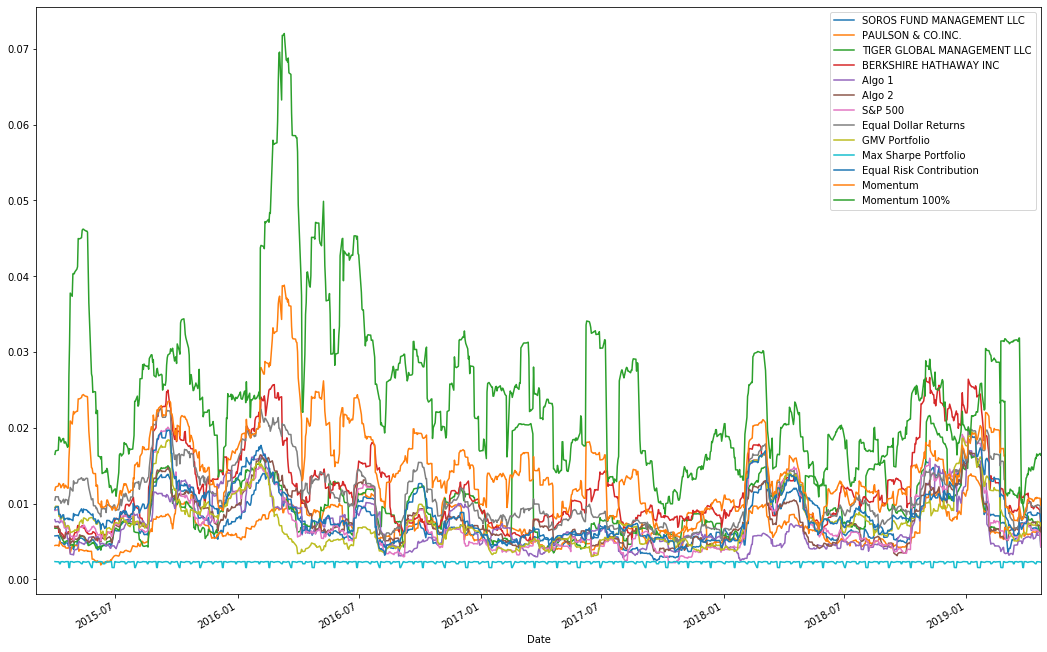

In [76]:
# Rolling Std Dev
all_returns.rolling(21).std().plot(figsize=(18,12))

### The  timeframe of stock returns that I was able to get (about 3 years) loooks like it was too short to be representative. The predicted returns of my max sharpe portfolio are too high, and its standard deviation is extremely low. Ideally, I would have had a larger sample size to work with. Because of the skewed nature of this portfolio, I am excluding it from the rest of the analysis.

In [77]:
all_returns.drop(columns=['Max Sharpe Portfolio'], inplace=True)

## Rolling Beta for the GMV Portfolio. Method 1

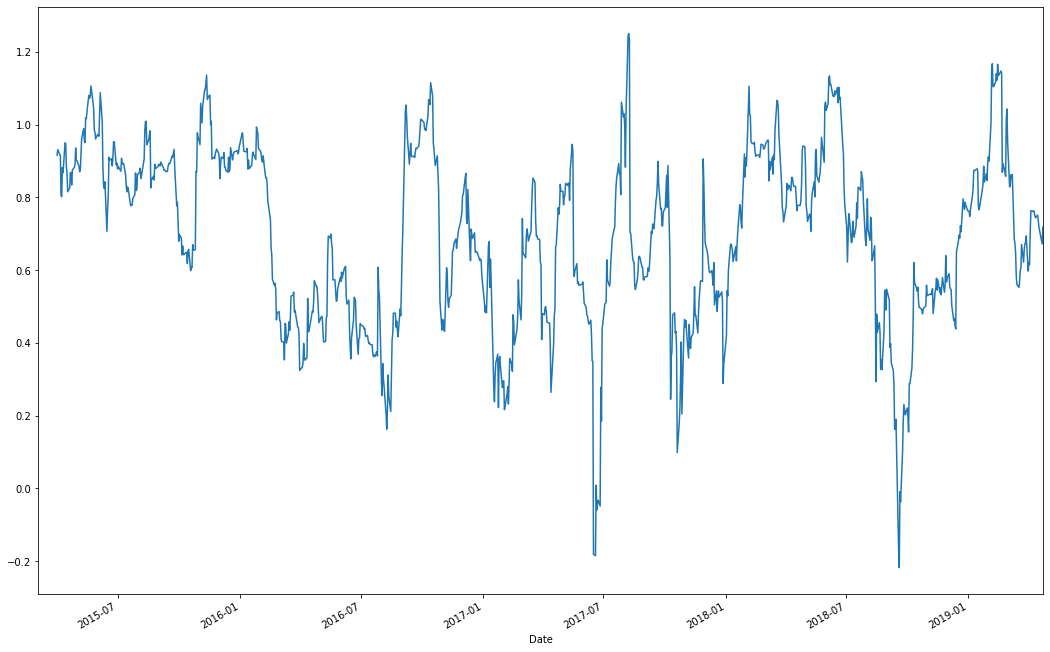

In [78]:
all_returns_rolling_cov=all_returns['GMV Portfolio'].rolling(21).cov(all_returns['S&P 500'])
rolling_market_var=all_returns['S&P 500'].rolling(21).var()
all_returns_rolling_beta=all_returns_rolling_cov/rolling_market_var
all_returns_rolling_beta.plot(figsize=(18,12))

### The GMV portfolio beta seems to be around .5 on average. This makes sense that a portfolio with low variance would only move about half as much as the market does.

## Rolling Betas for all of the alternatively weighted portfolios. Method 2.

In [79]:
my_rolled_rets=get_rolled_returns(all_returns[['Equal Dollar Returns', 'GMV Portfolio',
                                               'Equal Risk Contribution','Momentum', 'Momentum 100%','S&P 500']], 21)
my_rolled_betas=get_beta_from_windows(all_returns[['Equal Dollar Returns', 'GMV Portfolio',
                                               'Equal Risk Contribution', 'Momentum', 'Momentum 100%']],
                                      my_rolled_rets, 21)

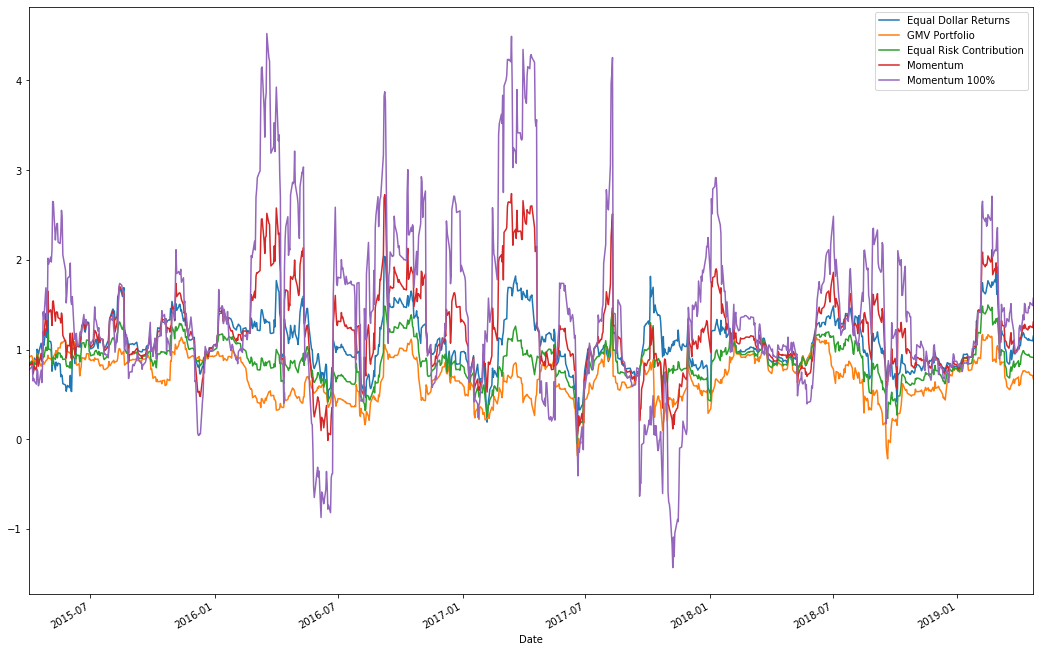

In [80]:
my_rolled_betas.plot(figsize=(18,12))

In [81]:
# Annualized Sharpe Ratios
my_sharpes=(all_returns.mean()*252)/(all_returns.std()*np.sqrt(252))
my_sharpes

SOROS FUND MANAGEMENT LLC      0.359034
PAULSON & CO.INC.             -0.473108
TIGER GLOBAL MANAGEMENT LLC   -0.120425
BERKSHIRE HATHAWAY INC         0.629941
Algo 1                         1.383268
Algo 2                         0.503342
S&P 500                        0.656761
Equal Dollar Returns           0.703421
GMV Portfolio                  0.467524
Equal Risk Contribution        0.635625
Momentum                       0.710004
Momentum 100%                  0.618466
dtype: float64

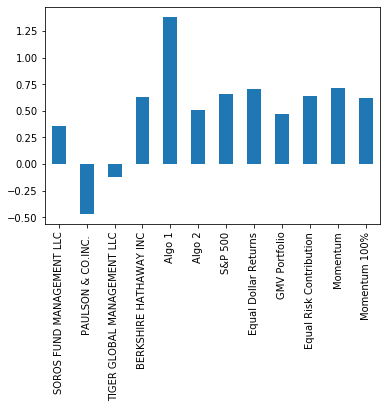

In [82]:
# Visualize the sharpe ratios as a bar plot
my_sharpes.plot.bar()

## Sortino Ratios

In [83]:
sortino_ratio(all_returns, 0, 252)

SOROS FUND MANAGEMENT LLC      0.393632
PAULSON & CO.INC.             -0.694342
TIGER GLOBAL MANAGEMENT LLC   -0.236607
BERKSHIRE HATHAWAY INC         0.710853
Algo 1                         2.436731
Algo 2                         0.595919
S&P 500                        0.757693
Equal Dollar Returns           0.994208
GMV Portfolio                  0.533970
Equal Risk Contribution        0.828455
Momentum                       0.962488
Momentum 100%                  0.647765
dtype: float64

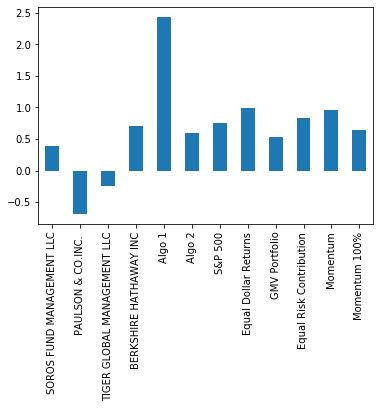

In [84]:
sortino_ratio(all_returns, 0, 252).plot.bar()

## These Sortino ratios paint a clearer picture of Algo 1's dominance. When only downside risk is considered, several portfolios' ratio of excess return to risk goes up. This suggests that their Sharpe Ratios are being unfairly penalized for having upside volatility. Interestingly, Paulson and Tiger both have lower Sortino ratios. This may mean that they have disproportionate downside volatility or left tail risk.

## Total Wealth at end of period

### Algo 1 was the best portfolio to be invested in. It had the highest Sharpe ratio by far, and produced about as much wealth as the momentum portfolios, though with a lot less volatility

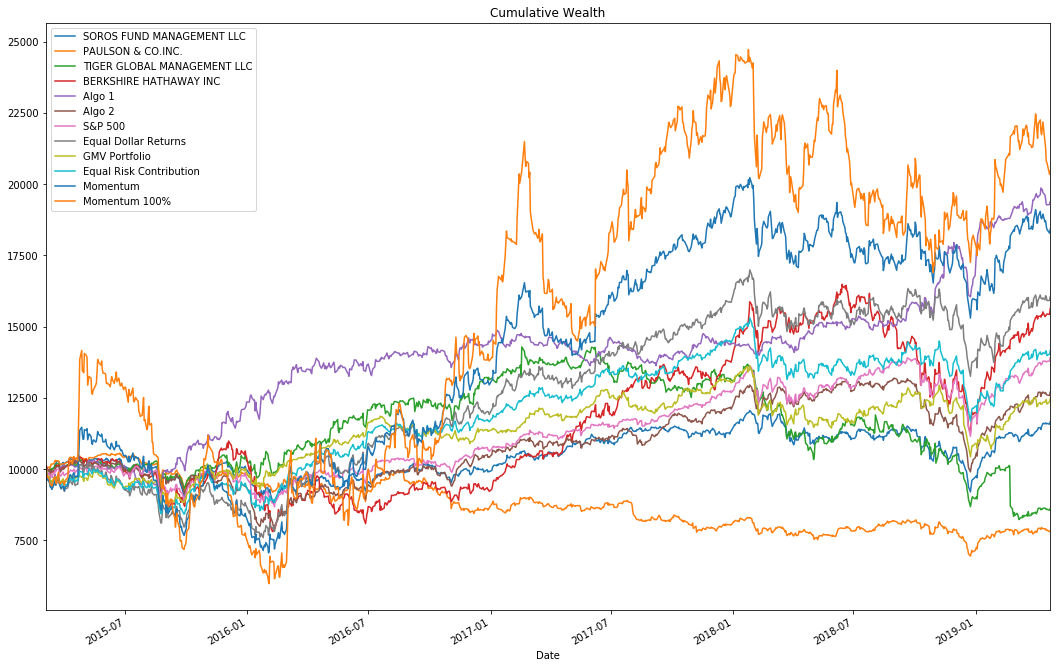

In [85]:
(10000*(1+all_returns).cumprod()).plot(figsize=(18,12), title='Cumulative Wealth')

## Include correlation analysis to determine which stocks (if any) are correlated

In [86]:
my_stock_returns.corr()

Symbol,JNJ,MO,XOM,VALE,BABA
Symbol,,,,,
JNJ,1.000000,0.358441,0.427391,0.204238,0.208317
MO,0.358441,1.000000,0.255911,0.096526,0.116000
XOM,0.427391,0.255911,1.000000,0.381230,0.254624
VALE,0.204238,0.096526,0.381230,1.000000,0.273577
BABA,0.208317,0.116000,0.254624,0.273577,1.000000


### Interestingly, these 5 stocks are only moderately correlated. BABA has pretty low pairwise correlations with all other stocks. I suppose this makes sense, since these 5 stocks are all in different industries...although I would have expected a higher correlation between XOM and VALE, since they're both involved with natural resources.

In [87]:
all_returns.corr().iloc[-6:, -6:]

,S&P 500,Equal Dollar Returns,GMV Portfolio,Equal Risk Contribution,Momentum,Momentum 100%
S&P 500,1.000000,0.755508,0.770717,0.811437,0.610252,0.412715
Equal Dollar Returns,0.755508,1.000000,0.760458,0.951012,0.883686,0.667428
GMV Portfolio,0.770717,0.760458,1.000000,0.919201,0.588059,0.373795
Equal Risk Contribution,0.811437,0.951012,0.919201,1.000000,0.800646,0.571468
Momentum,0.610252,0.883686,0.588059,0.800646,1.000000,0.938277
Momentum 100%,0.412715,0.667428,0.373795,0.571468,0.938277,1.000000


### All of these portfolios are pretty highly correlated with each other. That makes intuitive sense since they are made up of the same 5 stocks.
* ### As a 'sanity check' it makes good sense that the GMV portfolio would have a lower correlation with the extreme momentum 100% portfolio. 
* ### The Equal Risk Contribution portfolio also has a low correlation to the Momentum 100% portfolio.
* ### This can be interpreted as saying that the Momentum 100% portfolio has far from a balanced risk exposure; in fact it's concentrated 100% in 1 stock.

In [88]:
all_returns.corr()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P 500,Equal Dollar Returns,GMV Portfolio,Equal Risk Contribution,Momentum,Momentum 100%
SOROS FUND MANAGEMENT LLC,1.000000,0.699961,0.561246,0.754385,0.321175,0.826869,0.837908,0.652593,0.585070,0.667221,0.529510,0.360676
PAULSON & CO.INC.,0.699961,1.000000,0.434551,0.545465,0.268692,0.678214,0.669612,0.507858,0.484871,0.529521,0.390066,0.245803
TIGER GLOBAL MANAGEMENT LLC,0.561246,0.434551,1.000000,0.424465,0.164384,0.507414,0.624023,0.434836,0.511190,0.499944,0.336028,0.213387
BERKSHIRE HATHAWAY INC,0.754385,0.545465,0.424465,1.000000,0.291912,0.688112,0.751297,0.608966,0.490328,0.606944,0.503816,0.352034
Algo 1,0.321175,0.268692,0.164384,0.291912,1.000000,0.288214,0.279366,0.254907,0.168138,0.231482,0.197859,0.125923
Algo 2,0.826869,0.678214,0.507414,0.688112,0.288214,1.000000,0.858828,0.689425,0.596409,0.691693,0.572155,0.401334
S&P 500,0.837908,0.669612,0.624023,0.751297,0.279366,0.858828,1.000000,0.755508,0.770717,0.811437,0.610252,0.412715
Equal Dollar Returns,0.652593,0.507858,0.434836,0.608966,0.254907,0.689425,0.755508,1.000000,0.760458,0.951012,0.883686,0.667428
GMV Portfolio,0.585070,0.484871,0.511190,0.490328,0.168138,0.596409,0.770717,0.760458,1.000000,0.919201,0.588059,0.373795
Equal Risk Contribution,0.667221,0.529521,0.499944,0.606944,0.231482,0.691693,0.811437,0.951012,0.919201,1.000000,0.800646,0.571468


### All of my alternatively weighted portfolios are moderately correlated with the 4 'Whale' Funds and Algo 2.Algo 1 seems to be only lightly correlated with every other portfolio. An allocation to Algo 1 would make a lot of sense assuming we can be reasonably sure that its great returns are reproducible

### Compute Drawdowns of the portfolios. Drawdowns are calculated cumulatively with the following function

In [89]:
def drawdown(return_series: pd.Series):
    wealth_index=1000*(1+return_series).cumprod()
    previous_peaks=wealth_index.cummax()
    drawdowns=(wealth_index-previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdowns
    })

In [90]:
eq_draw=drawdown(all_returns['Equal Dollar Returns'])
gmv_draw=drawdown(all_returns['GMV Portfolio'])
risk_draw=drawdown(all_returns['Equal Risk Contribution'])
momentum_draw=drawdown(all_returns['Momentum'])
momentum_100_draw=drawdown(all_returns['Momentum 100%'])

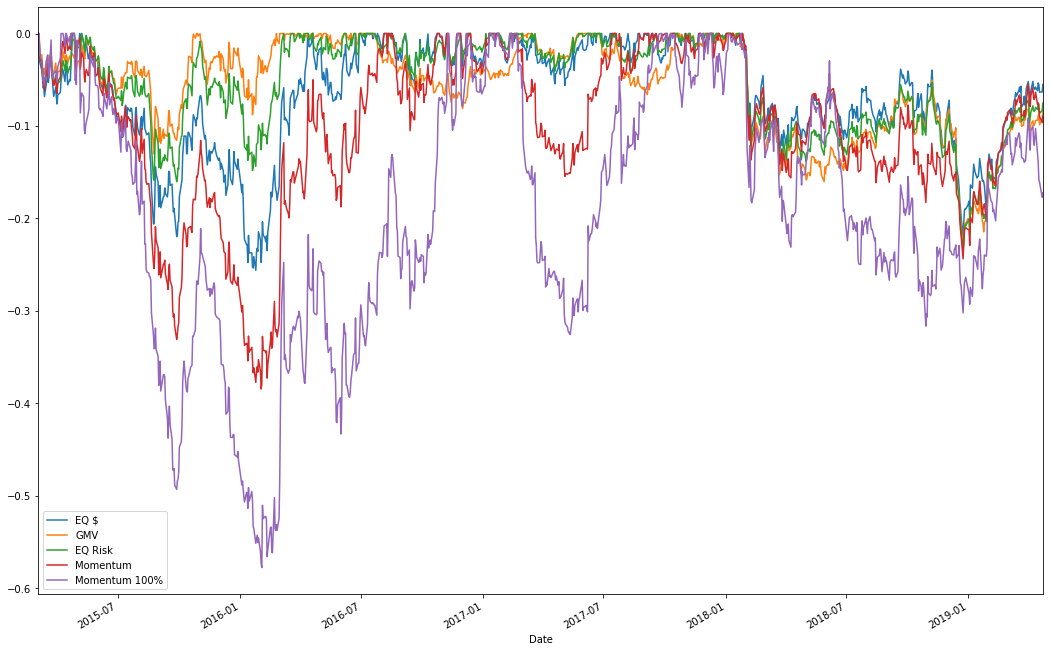

In [91]:
ax=eq_draw['Drawdown'].plot(figsize=(18,12), label='EQ $', legend=True)
gmv_draw['Drawdown'].plot(ax=ax, label='GMV', legend=True)
risk_draw['Drawdown'].plot(ax=ax, label='EQ Risk', legend=True)
momentum_draw['Drawdown'].plot(ax=ax, label='Momentum', legend=True)
momentum_100_draw['Drawdown'].plot(ax=ax, label='Momentum 100%', legend=True)

### No surprises here: The momentum portfolios have the biggest drawdowns. The more the portfolio is concentrated in a single stock, the worse the losses are. The GMV Portfolio and the Equal Risk Contribution Portfolio both have much lower drawdowns

In [92]:
drawdown_df=pd.concat([pd.DataFrame(eq_draw['Drawdown']),
           pd.DataFrame(gmv_draw['Drawdown']), pd.DataFrame(risk_draw['Drawdown']), pd.DataFrame(momentum_draw['Drawdown']), pd.DataFrame(momentum_100_draw['Drawdown'])], axis=1)
drawdown_df.columns=['EQ $', 'GMV', 'EQ Risk', 'Momentum', 'Momentum 100%']

In [93]:
drawdown_df.describe()

,EQ $,GMV,EQ Risk,Momentum,Momentum 100%
count,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000
mean,-0.063698,-0.056522,-0.054254,-0.101225,-0.190089
std,0.058028,0.050004,0.051160,0.084358,0.135363
min,-0.256000,-0.234390,-0.236743,-0.384365,-0.577554
25%,-0.093643,-0.093987,-0.095569,-0.144085,-0.272320
50%,-0.053693,-0.043392,-0.035291,-0.089897,-0.186964
75%,-0.013518,-0.015583,-0.009860,-0.030781,-0.077668
max,0.000000,0.000000,0.000000,0.000000,0.000000


## Style Analysis for all of the Portfolios. I will run a regression using the 3 Fama-French factors

### The data I have for the Fama-French factor returns is monthly data and it only goes through December 2018. So I will modify my portfolios so that they have monthly data and they match the timeframe.

In [94]:
all_returns_modified=all_returns.resample('1M').sum()
all_returns_modified.index=all_returns_modified.index.strftime('%Y-%m')
all_returns_modified=all_returns_modified.loc[:'2018-12']

In [95]:
X2=exp_var.values
Y2=all_returns_modified.values
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.5, random_state=0)
my_regressor2=LinearRegression()
my_regressor2.fit(X2_train, Y2_train)
df_regression2=pd.DataFrame(my_regressor2.coef_, index=all_returns_modified.columns, columns=exp_var.columns)

In [96]:
df_regression2

,Mkt-RF,SMB,HML
SOROS FUND MANAGEMENT LLC,0.721749,0.057939,-0.249356
PAULSON & CO.INC.,0.448366,0.166409,-0.099763
TIGER GLOBAL MANAGEMENT LLC,0.779079,-0.201926,0.130369
BERKSHIRE HATHAWAY INC,1.087713,-0.032260,-0.255324
Algo 1,0.111509,0.090812,0.021389
Algo 2,0.901029,0.522216,0.177007
S&P 500,0.973418,-0.122235,-0.026302
Equal Dollar Returns,1.229274,-0.790660,0.582779
GMV Portfolio,0.781285,-0.562540,0.037641
Equal Risk Contribution,1.031611,-0.672459,0.308762


In [97]:
df_regression2.describe()

,Mkt-RF,SMB,HML
count,12.000000,12.000000,12.000000
mean,1.199005,-0.276142,0.531418
std,1.033308,0.468473,1.203500
min,0.111509,-0.915706,-0.255324
25%,0.764747,-0.702009,-0.044667
50%,0.937223,-0.162081,0.084005
75%,1.123103,0.066157,0.377267
max,4.037981,0.522216,3.916067


### Some observations: Soros and Paulson both have a small growth tilt, and their exposure to the Market factor is significantly less than 1. Tiger Global has more of a large value tilt. Tiger's poor performance makes sense now, since this data is from between 2015 and 2018 and value stocks have been underperforming for about 10 years now. 
* ### My Equal Dollar Weighted Portfolio has a huge value bias which is expected, since equally weighted indices rebalance away from high growth stocks.
* ### I'm not sure what to make of the 2 momentum portfolios. Both have huge exposure to the market factor, and are also heavily skewed towards large cap and value. Momentum traditionally is a growth strategy. It could be due to my particular stock selection, or the fairly short period of sample returns.
* ### Algo 1 is very mysterious. It has very low Market exposure, a slight small tilt, and it's almost neutral between value and growth. I wonder how it achieved its high returns. It's possible that using other factors in the regression would have resulted in higher coefficients for Algo 1. Perhaps those factors would be more macro in nature.

# Other Sources used:
## [Scikit-Learn Regression Guide](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)
## [Random pages on StackOverFlow](https://stackoverflow.com/questions/50997339/convert-daily-data-in-pandas-dataframe-to-monthly-data)